In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

In [3]:
EN_x = pd.read_csv('EN_exog.csv')

In [4]:
EN_x.head()

,Unnamed: 0,0
0,0,16.730904
1,1,10.894386
2,2,19.499658
3,3,15.090033
4,4,10.817456


In [5]:
dates['Date'] = pd.to_datetime(dates[0])
y.set_index(dates['Date'],inplace=True)
X.set_index(dates['Date'],inplace=True)

In [6]:
EN_x.shape

(2923, 2)

In [7]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries, ARIAMA only consider y, setting X has no effect
X = X.iloc[:, 0: 500]

# first with the last year as test
# use the last 365 of training set as validation set
test_size =365
val_size=365
length = X.shape[0]
train1_X = X[0:length-test_size*2]
val1_X = X[length-test_size*2:length-test_size]
train1_y = y[0:length-test_size*2]
val1_y = y[length-test_size*2:length-test_size]
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

#without validation set
train1_X2 = X[0:length-test_size]
train1_y2 = y[0:length-test_size]

# second with the last 2 year as test
test_size2 =365*2
train2_X = X[0:length-test_size2-val_size]
val2_X = X[length-test_size2-val_size:length-test_size2]
train2_y = y[0:length-test_size2-val_size]
val2_y = y[length-test_size2-val_size:length-test_size2]
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

#without validation set
train2_X2 = X[0:length-test_size2]
train2_y2 = y[0:length-test_size2]


print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3653, 500)  train1 y: (3653, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
train2 X: (3288, 500)  train2 y: (3288, 1)  Test2 X: (365, 500)  Test2 y: (365, 1)


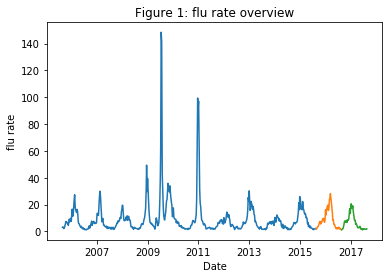

In [8]:
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = train1_y.copy()
df['y'] = train1_y.values

fig, ax = plt.subplots()
ax.plot(date[:3653],df.y,date[3653:4018],y.values[3653:4018],date[4018:],y.values[4018:])
plt.title("Figure 1: flu rate overview")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [9]:
df1 = EN_x.copy()
#df1['rate'] = train1_y2
df1.head()

,Unnamed: 0,0
0,0,16.730904
1,1,10.894386
2,2,19.499658
3,3,15.090033
4,4,10.817456


In [10]:
df=df1.iloc[:,1:2].copy()

In [11]:
df.head()

,0
0,16.730904
1,10.894386
2,19.499658
3,15.090033
4,10.817456


In [12]:
df3 = df[:2558].copy()
df4 = df[2558:].copy()

In [13]:
# the above plot shows the possible significant AR term may be 5
# anyway, just tune the possible choices
from statsmodels.tsa.arima_model import ARIMA
# fit model
model=ARIMA(endog=train1_y2[4*365:].values,exog=df3,order=[2,1,14])
model_fit = model.fit(disp=0)
print(model_fit.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2557
Model:                ARIMA(2, 1, 14)   Log Likelihood                 236.698
Method:                       css-mle   S.D. of innovations              0.219
Date:                Thu, 06 Sep 2018   AIC                           -435.395
Time:                        00:08:41   BIC                           -324.310
Sample:                             1   HQIC                          -395.112
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.004     -1.243      0.214      -0.012       0.003
0              0.0002      0.000      1.242      0.214      -0.000       0.001
ar.L1.D.y      0.9971      0.063     15.825      0.0

In [14]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(endog=train1_y2[4*365:].values,
            exog=df3,
            order=[1,2,15])
model_fit = model.fit(disp=0)
print(model_fit.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 2556
Model:                ARIMA(1, 2, 15)   Log Likelihood                 230.184
Method:                       css-mle   S.D. of innovations              0.220
Date:                Thu, 06 Sep 2018   AIC                           -422.368
Time:                        03:01:35   BIC                           -311.291
Sample:                             2   HQIC                          -382.087
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0022      0.001      3.269      0.001       0.001       0.004
0              -0.0003   7.61e-05     -3.288      0.001      -0.000      -0.000
ar.L1.D2.y     -0.1203        nan        nan    

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [14]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(endog=train1_y2[4*365:].values,
            exog=df3,
            order=[2,1,15])
model_fit = model.fit(disp=0)
print(model_fit.summary())


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2557
Model:                ARIMA(2, 1, 15)   Log Likelihood                 246.135
Method:                       css-mle   S.D. of innovations              0.218
Date:                Thu, 06 Sep 2018   AIC                           -452.270
Time:                        03:28:58   BIC                           -335.339
Sample:                             1   HQIC                          -409.867
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0072      0.048     -0.150      0.881      -0.101       0.087
0              0.0002      0.000      1.211      0.226      -0.000       0.001
ar.L1.D.y      1.8795      0.021     88.904      0.0

In [13]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)

train1 = train1_y2[4*365:].values
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:2558].copy()
df4 = df[2558:].copy()

history = [x for x in train1]
predict = list()
training_mod = sm.tsa.statespace.SARIMAX(endog =train1,
                                  exog=df3,
                                  trend='n', order=(2,1,15),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
training_res = training_mod.fit()
training_mod.fit(disp=0)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [14]:
train1 = train1_y2[4*365:].values
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:2558].copy()
df4 = df[2558:].copy()

history = [x for x in train1]
predict = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:2558+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4.iloc[[t]]
    output = model_fit.forecast(steps=1,exog=exog_test)
    yhat = output.values[0]
    print(yhat)
    predict.append(yhat)
    obs = test1[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict)
rmse1 = sqrt(mean_squared_error(test1, predict))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

1.137980831579147
1
1.0888530921970951
2
1.0679330309194215
3
1.17438346951169
4
1.1884892282087194
5
1.2320774777583172
6
1.2579513876223687
7
1.2834503132888015
8
1.3297242575355117
9
1.3388196799460665
10
1.5095751535149091
11
1.5716435412567489
12
1.662484297386338
13
1.735460537548856
14
1.8087503622333199
15
1.8998849617291076
16
1.9166973369125642
17
1.9558825597617433
18
1.954262968428814
19
1.9820493350300203
20
1.9918916416590233
21
2.001977227552972
22
2.0298743204609515
23
2.0214927640371005
24
2.433184347250797
25
2.604460895421976
26
2.809115164572379
27
2.9952323303848267
28
3.175581508421877
29
3.381052302652274
30
3.4409676214452163
31
3.9154492609996865
32
4.154318569459781
33
4.426352240085762
34
4.677589205681198
35
4.923716493921521
36
5.193961273954897
37
5.2526920194504285
38
5.887372659199897
39
6.206268550456619
40
6.55570159286876
41
6.891039789370823
42
7.213178335926088
43
7.564432119984262
44
7.6517692683832825
45
7.61219668581109
46
7.60222207265131
47
7.6

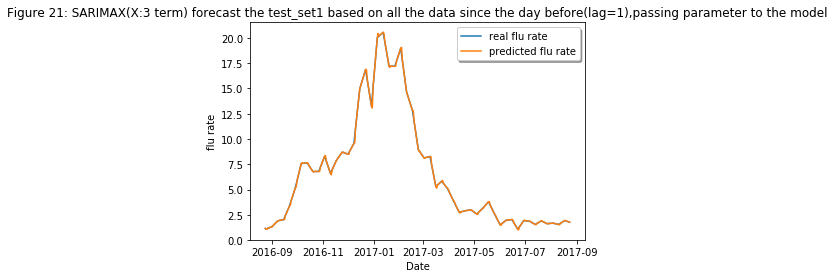

In [15]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 21: SARIMAX(X:3 term) forecast the test_set1 based on all the data since the day before(lag=1),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [14]:
## lag=5

train1 = train1_y2[4*365:4018-4].values
test = y.values[4018-4:]
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:2558].copy()
df4 = df[2558-4:].copy()


history = [x for x in train1]
predict2 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:2558-4+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+5]
    output = model_fit.forecast(steps=5,exog=exog_test)
    yhat = output.values[4]
    print(yhat)
    predict2.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict2)
rmse1 = sqrt(mean_squared_error(test1, predict2))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict2
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

1.218123638130897
1
1.0480002105371748
2
1.0283248211400304
3
0.984106514347331
4
0.9809487927052938
5
1.0407192084023063
6
1.037835895263148
7
1.3544254124883264
8
1.2942506455072311
9
1.313988526936883
10
1.3000293335460815
11
1.3282568919147506
12
1.4188338867876207
13
1.448657155659491
14
1.9000165570343694
15
1.8912398918650155
16
1.9162525156883627
17
1.9060527142175643
18
1.9355030933266968
19
2.0245199574604777
20
2.0665112191234867
21
2.1138015508556856
22
2.033109147095758
23
2.029312735174571
24
1.9911677450631848
25
1.9914873155616675
26
2.0522892240668846
27
2.068234377511149
28
3.2737344414163716
29
3.3716187364520094
30
3.451584222080156
31
3.485851505764479
32
3.5518542954687846
33
3.7025086001702427
34
3.79286679267176
35
5.0557775763560215
36
5.23558354729179
37
5.318094414556702
38
5.345143105991954
39
5.404043781444014
40
5.543953033896169
41
5.629285344748449
42
7.368645112620421
43
7.621863410113264
44
7.7263989895724485
45
7.790332198867733
46
7.860781626116371
4

In [15]:
mae1 = mean_absolute_error(test1, predict2)
rmse1 = sqrt(mean_squared_error(test1, predict2))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict2
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

0.4165830271244683 0.7960408957425557 0.9899377242357238


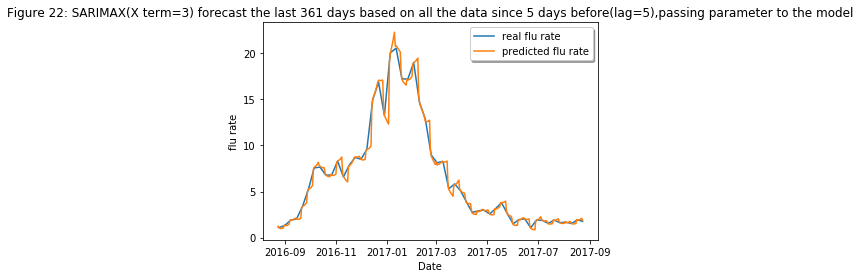

In [16]:
## lag=5
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 22: SARIMAX(X term=3) forecast the last 361 days based on all the data since 5 days before(lag=5),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [17]:
## lag=10
train1 = train1_y2[4*365:4018-9].values
test = y.values[4018-9:]
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:2558].copy()
df4 = df[2558-9:].copy()

history = [x for x in train1]
predict3 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:2558-9+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+10]
    output = model_fit.forecast(steps=10,exog=exog_test)
    yhat = output.values[9]
    print(yhat)
    predict3.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict3)
rmse1 = sqrt(mean_squared_error(test1, predict3))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict3
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

1.3369198934235351
1
1.2600236630980277
2
1.2692593412624786
3
1.35705673158885
4
1.3521573535035711
5
1.083403053864308
6
0.9090001586008026
7
0.909246599853291
8
0.8485819611005984
9
0.8649273212009809
10
0.9685827533031867
11
0.9734146866697504
12
1.4556544078396434
13
1.3403922286817302
14
1.3896563889540314
15
1.3615589802654744
16
1.382900280156579
17
1.4879968357585314
18
1.4942254303239466
19
2.1295784479647097
20
2.02138192254137
21
2.0714778343786615
22
2.0431736689104345
23
2.05097124755814
24
2.142994212538694
25
2.1546354633254654
26
2.2009265030850593
27
2.0477429801018587
28
2.0605488060266226
29
1.9969145380394306
30
1.9920205615838025
31
2.075158897642542
32
2.0824573487982225
33
3.809798096220821
34
3.7513086480318907
35
3.872423182620997
36
3.897675959490061
37
3.9060242892514028
38
4.029936781443172
39
4.049250882416248
40
5.763010329088753
41
5.719257102485477
42
5.832758605773759
43
5.834693053030488
44
5.8171312266569775
45
5.9177191747392355
46
5.917014025698257

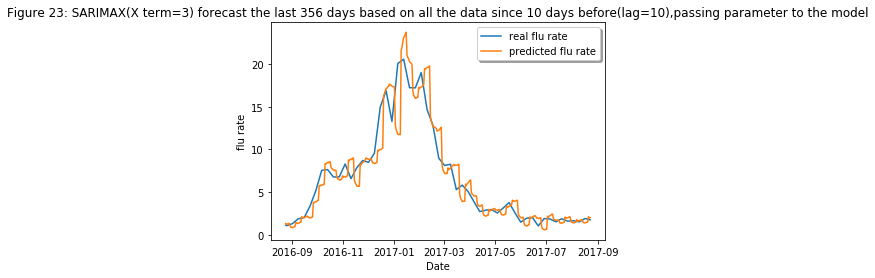

In [18]:
# visualize lag=10
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict3,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 23: SARIMAX(X term=3) forecast the last 356 days based on all the data since 10 days before(lag=10),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [19]:
## lag=14
train1 = train1_y2[4*365:4018-13].values
test = y.values[4018-13:]
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:2558].copy()
df4 = df[2558-13:].copy()

history = [x for x in train1]
predict4 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:2558-13+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+14]
    output = model_fit.forecast(steps=14,exog=exog_test)
    yhat = output.values[13]
    print(yhat)
    predict4.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict4)
rmse1 = sqrt(mean_squared_error(test1, predict4))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict4
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

1.9633045280185104
1
1.997829141731376
2
1.4266208661363744
3
1.26136035575304
4
1.2710873099021551
5
1.2109046806344843
6
1.2266076594940583
7
1.3330636799291968
8
1.3323308453389302
9
1.0155324950063633
10
0.8224193563948239
11
0.8454590530544361
12
0.7959315349336576
13
0.8245876727171089
14
0.949316877009021
15
0.9559143059156495
16
1.5187459987082024
17
1.3621241851303112
18
1.407793056803024
19
1.3597929451302222
20
1.384270419212984
21
1.5068609541666946
22
1.5150929222296414
23
2.2522706114401516
24
2.093894257408534
25
2.1307112179666077
26
2.072568894369048
27
2.0788834985093696
28
2.182968943319196
29
2.1984901524078904
30
2.2427590779793047
31
2.054037127276237
32
2.0719323180117413
33
1.9987968135825391
34
2.0012373055282535
35
2.0967917911641845
36
2.104121212786035
37
4.122617959973605
38
3.974977616447498
39
4.045561157783354
40
3.994089205782739
41
4.002689434070764
42
4.137806777602181
43
4.150344917616372
44
6.142720525723142
45
6.004465710818936
46
6.061229766462016

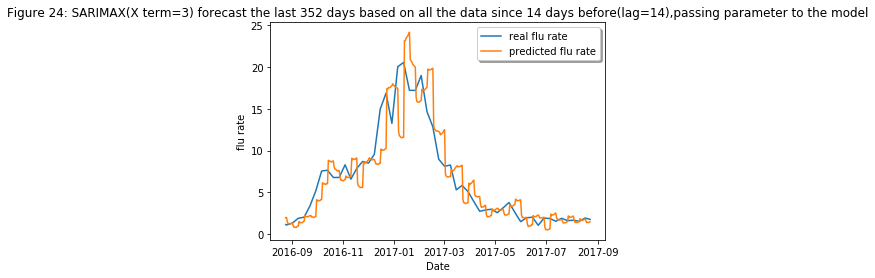

In [20]:
# visualize lag=14
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict4,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 24: SARIMAX(X term=3) forecast the last 352 days based on all the data since 14 days before(lag=14),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [21]:
## lag=28
train1 = train1_y2[4*365:4018-27].values
test = y.values[4018-27:]
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:2558].copy()
df4 = df[2558-27:].copy()

history = [x for x in train1]
predict5 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:2558-27+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+28]
    output = model_fit.forecast(steps=28,exog=exog_test)
    yhat = output.values[27]
    print(yhat)
    predict5.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict5)
rmse1 = sqrt(mean_squared_error(test1, predict5))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict5
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

3.209708492282442
1
3.2671078666191544
2
2.054881283478794
3
1.882907832779078
4
1.8807589540325174
5
1.7775275159528163
6
1.7752833376048194
7
1.8652190679080831
8
1.8474750986982817
9
1.9880200736509508
10
1.7541920528373482
11
1.7995938074493734
12
1.7561984116107798
13
1.7975839053352707
14
1.9462360449558953
15
1.987951597349113
16
1.352738005953598
17
1.170454007438129
18
1.190569957506387
19
1.1304677455827956
20
1.1446192406717688
21
1.271740837971447
22
1.2793248273863524
23
0.9405725495536361
24
0.7254535805484554
25
0.7616316708572398
26
0.7144797430889955
27
0.7355217101247163
28
0.8827363634471351
29
0.9038092957863566
30
1.5649227329529412
31
1.375247318280922
32
1.4231579943822337
33
1.3687315148257395
34
1.385625469223737
35
1.522896678249089
36
1.5343538873947715
37
2.375932564258702
38
2.1815003949863683
39
2.215063937294804
40
2.1411809849036665
41
2.1359196673539267
42
2.248121896837837
43
2.260842475908127
44
2.3123440583151083
45
2.091809299645116
46
2.11240556635

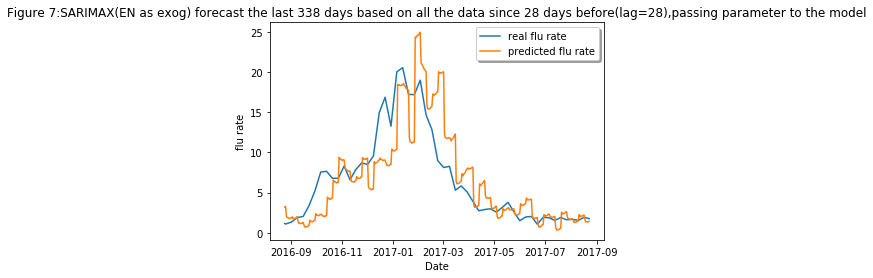

In [22]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict5,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 7:SARIMAX(EN as exog) forecast the last 338 days based on all the data since 28 days before(lag=28),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

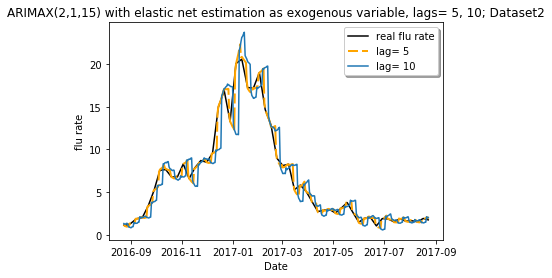

In [23]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate', color='black')
ax.plot(date[4018:],predict2,dashes=[5,2,20,2], linewidth=2,color='orange',label='lag= 5')
ax.plot(date[4018:],predict3,label='lag= 10')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("ARIMAX(2,1,15) with elastic net estimation as exogenous variable, lags= 5, 10; Dataset2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("arimax_en_510_test2.pdf", bbox_inches='tight')

plt.show()

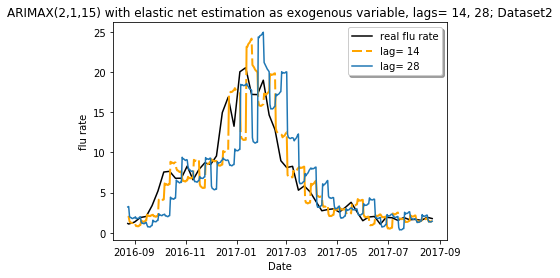

In [24]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate', color='black')
ax.plot(date[4018:],predict4,dashes=[5,2,20,2], linewidth=2,color='orange',label='lag= 14')
ax.plot(date[4018:],predict5,label='lag= 28')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("ARIMAX(2,1,15) with elastic net estimation as exogenous variable, lags= 14, 28; Dataset2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("arimax_en_1428_test2.pdf", bbox_inches='tight')

plt.show()

In [15]:
corr_y['y_pred'].to_csv('ARIMAX_EN_t2.csv',header=False)